In [1]:
import os
import cv2
from ultralytics import YOLO

# ---------------------------
# CONFIG
# ---------------------------
MODEL_PATH = "models/fish_yolov86/weights/best.pt"
TEST_IMAGES = "data/images/test"
TEST_LABELS = "data/labels/test"

SAVE_MISCLASSIFIED = True

OUT_PRED_DIR = "misclassified_yolo"              # predictions (RED)
OUT_GT_DIR = "misclassified_ground_truth"        # actual labels (GREEN)

CLASSES = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

os.makedirs(OUT_PRED_DIR, exist_ok=True)
os.makedirs(OUT_GT_DIR, exist_ok=True)

model = YOLO(MODEL_PATH)

# ---------------------------
# HELPER: Read YOLO GT labels
# ---------------------------
def read_yolo_label(label_path, img_w, img_h):
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:])

            # Convert normalized → pixel xyxy
            x1 = int((xc - w / 2) * img_w)
            y1 = int((yc - h / 2) * img_h)
            x2 = int((xc + w / 2) * img_w)
            y2 = int((yc + h / 2) * img_h)

            boxes.append((cls, x1, y1, x2, y2))

    return boxes


# ---------------------------
# MAIN LOOP
# ---------------------------
misclassified = []

for img_name in os.listdir(TEST_IMAGES):
    if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(TEST_IMAGES, img_name)
    label_path = os.path.join(
        TEST_LABELS, img_name.replace(".jpg", ".txt").replace(".png", ".txt")
    )

    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # --- Read ground truth ---
    gt_boxes = read_yolo_label(label_path, img_w, img_h)
    gt_classes = [b[0] for b in gt_boxes]

    # --- Predict ---
    results = model.predict(img_path, conf=0.25, verbose=False)[0]
    pred_classes = [
        int(box.cls[0]) for box in results.boxes
    ] if results.boxes is not None else []

    # ---------------------------
    # If misclassified
    # ---------------------------
    if sorted(gt_classes) != sorted(pred_classes):
        misclassified.append({
            "image": img_name,
            "gt": [CLASSES[c] for c in gt_classes],
            "pred": [CLASSES[c] for c in pred_classes]
        })

        if SAVE_MISCLASSIFIED:

            # COPY of original for prediction drawing
            pred_img = img.copy()

            # COPY of original for GT drawing
            gt_img = img.copy()

            # ---------------------------
            # DRAW GROUND TRUTH (GREEN)
            # ---------------------------
            for cls, x1, y1, x2, y2 in gt_boxes:
                cls_name = CLASSES[cls]

                cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(
                    gt_img,
                    f"GT: {cls_name}",
                    (x1, max(y1 - 8, 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0, 255, 0),
                    2
                )

            # Save ground-truth only image
            cv2.imwrite(os.path.join(OUT_GT_DIR, img_name), gt_img)

            # ---------------------------
            # DRAW PREDICTIONS (RED)
            # ---------------------------
            if results.boxes is not None:
                for box in results.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    cls_id = int(box.cls[0])
                    cls_name = CLASSES[cls_id]

                    cv2.rectangle(pred_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                    cv2.putText(
                        pred_img,
                        f"Pred: {cls_name}",
                        (x1, max(y1 - 8, 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (0, 0, 255),
                        2
                    )

            # Save predicted result only
            cv2.imwrite(os.path.join(OUT_PRED_DIR, img_name), pred_img)



# ---------------------------
# SUMMARY
# ---------------------------
print("\nTotal Misclassified:", len(misclassified))
for m in misclassified:
    print(m)



Total Misclassified: 62
{'image': 'IMG_2446_jpeg_jpg.rf.06ee05e92df8e3c33073147d8f595211.jpg', 'gt': ['shark', 'fish', 'fish', 'fish', 'fish', 'fish', 'fish', 'shark'], 'pred': ['fish', 'shark', 'fish', 'fish', 'fish', 'fish', 'shark', 'fish', 'fish', 'shark']}
{'image': 'IMG_2395_jpeg_jpg.rf.9f1503ad3b7a7c7938daed057cc4e9bc.jpg', 'gt': ['fish', 'fish', 'fish', 'fish', 'fish', 'fish', 'fish', 'fish'], 'pred': ['fish', 'fish', 'fish', 'fish', 'fish']}
{'image': 'objects365_v2_01965563_jpg.rf.a51a55e85f5f2e11072d9d8b3d2df2f5.jpg', 'gt': ['penguin', 'penguin', 'penguin', 'penguin', 'penguin'], 'pred': ['penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin']}
{'image': 'IMG_2380_jpeg_jpg.rf.a23809682eb1466c1136ca0f55de8fb5.jpg', 'gt': ['fish'], 'pred': ['fish', 'fish', 'fish', 'fish']}
{'image': 'IMG_3129_jpeg_jpg.rf.90c472dcdf9b6713ec767cc97560ceca.jpg', 'gt': ['starfish'], 'pred': []}
{'image': '00000016_jpg.rf.089d745d3ce89e57c3f61a5a59e3789d.jpg', 'gt':

In [1]:
from ultralytics import YOLO

model = YOLO("../models/fish_yolov87/weights/best.pt")

# Run evaluation on your test set
results = model.val(data="../data/dataset.yaml")   # or your dataset YAML

# Print metrics
print("mAP50:", results.box.map50)
print("mAP50-95:", results.box.map)
print("Precision:", results.box.mp)
print("Recall:", results.box.mr)

# Class-wise AP
print("\nClass-wise AP:")
print(results.box.maps)


Ultralytics 8.3.229 🚀 Python-3.11.2 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5601.8±773.7 MB/s, size: 321.5 KB)
val: Scanning /workspace/Jaasia/Fish_Detection/data/labels/valid_aug.cache... 595 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 595/595 3.2Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 38/38 19.4it/s 2.0s0.1s
                   all        595       3206      0.798      0.637      0.696      0.433
                  fish        238       1197      0.833      0.619      0.718      0.392
             jellyfish         42        679      0.865      0.847      0.913      0.605
               penguin         70        427      0.555       0.42      0.377      0.214
                puffin         77        329      0.703      0.547      0.592      0.331
 

In [3]:
from ultralytics import YOLO

model = YOLO("models/fish_yolov86/weights/best.pt")
model.info()  # instead of model.summary()

print(model.model)



Model summary: 169 layers, 25,860,373 parameters, 0 gradients, 79.1 GFLOPs
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

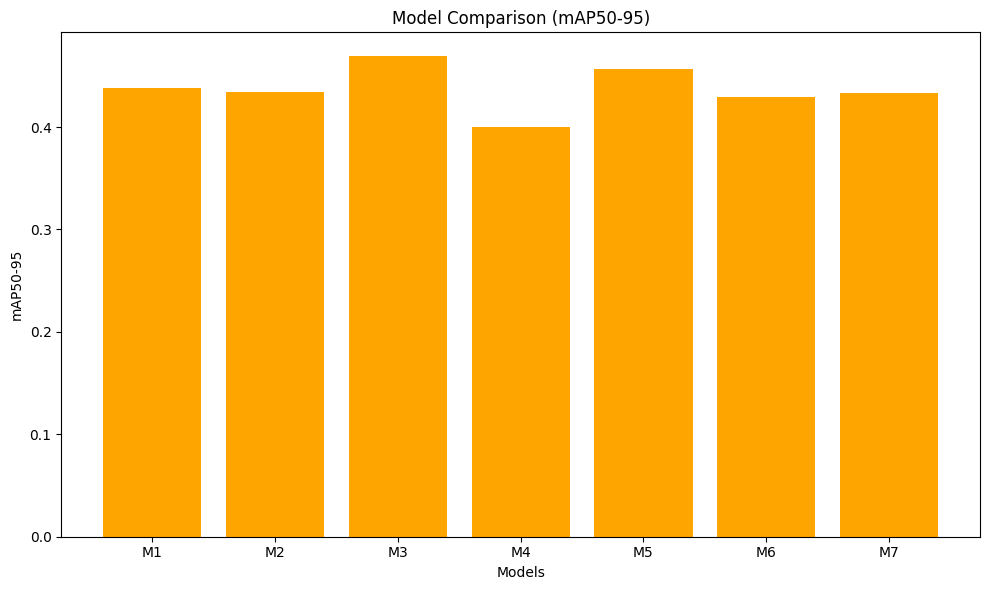

In [2]:
import matplotlib.pyplot as plt

models = ["M1","M2","M3","M4","M5","M6","M7"]
map50_95 = [0.438,0.434,0.469,0.400,0.457,0.429,0.433]

plt.figure(figsize=(10,6))
plt.bar(models, map50_95, color='orange')
plt.xlabel("Models")
plt.ylabel("mAP50-95")
plt.title("Model Comparison (mAP50-95)")
plt.tight_layout()
plt.show()
